# import lib

In [1]:
%run 'common.ipynb'

In [119]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict
from sklearn.model_selection import cross_val_score, KFold
from fbprophet import Prophet
import pickle
import lightgbm 

# Read data

In [84]:
origin_df = pd.read_csv('processed_train.csv')

In [85]:
df = origin_df.copy()
df.head(10)

Description        y1        y2        x1        x2        x3  \
0  2016-01-01 00:00:00  0.008133  0.805288  0.934119  0.182838  0.282637   
1  2016-01-01 00:05:00  0.008964  0.799772  0.934014  0.180689  0.281720   
2  2016-01-01 00:10:00  0.008906  0.809219  0.934031  0.181439  0.282202   
3  2016-01-01 00:15:00  0.008469  0.804602  0.934367  0.182620  0.282305   
4  2016-01-01 00:20:00  0.006882  0.799026  0.934884  0.180871  0.281051   
5  2016-01-01 00:25:00  0.008513  0.801384  0.933830  0.181452  0.282652   
6  2016-01-01 00:30:00  0.008589  0.799620  0.933954  0.181254  0.282584   
7  2016-01-01 00:35:00  0.008653  0.804140  0.933915  0.182905  0.283356   
8  2016-01-01 00:40:00  0.008137  0.802380  0.934468  0.182601  0.282141   
9  2016-01-01 00:45:00  0.007969  0.806117  0.934372  0.183060  0.282572   

         x4        x5        x6        x7  ...  hour month  minute  year  \
0  0.612302  0.218844  0.036615  0.695623  ...     0     1       0  2016   
1  0.611908  0.220869  0.037616  0.693026  ...     0     1       5  2016   
2  0.610927  0.222187  0.034264  0.692654  ...     0     1      10  2016   
3  0.612801  0.221935  0.034894  0.693397  ...     0     1      15  2016   
4  0.610566  0.218883  0.038596  0.690928  ...     0     1      20  2016   
5  0.612147  0.222160  0.037119  0.692054  ...     0     1      25  2016   
6  0.612522  0.225124  0.030487  0.691256  ...     0     1      30  2016   
7  0.611829  0.223631  0.031999  0.691691  ...     0     1      35  2016   
8  0.612130  0.214388  0.033619  0.692055  ...     0     1      40  2016   
9  0.613364  0.223763  0.030205  0.695446  ...     0     1      45  2016   

   year_month            Timestamp day day_of_week  target  quarter  
0     2016-01  2016-01-01 00:00:00   1           4      y2        1  
1     2016-01  2016-01-01 00:05:00   1           4      y2        1  
2     2016-01  2016-01-01 00:10:00   1           4      y2        1  
3     2016-01  2016-01-01 00:15:00   1           4      y2        1  
4     2016-01  2016-01-01 00:20:00   1           4      y2        1  
5     2016-01  2016-01-01 00:25:00   1           4      y2        1  
6     2016-01  2016-01-01 00:30:00   1           4      y2        1  
7     2016-01  2016-01-01 00:35:00   1           4      y2        1  
8     2016-01  2016-01-01 00:40:00   1           4      y2        1  
9     2016-01  2016-01-01 00:45:00   1           4      y2        1  

[10 rows x 22 columns]

In [86]:
df['Timestamp'] = pd.to_datetime(df['Description'], format='%Y-%m-%d %H:%M:%S')

In [87]:
df.shape

(157836, 22)

In [88]:
features = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'month', 'quarter']
target = ['y1', 'y2']

# Model selection

In [89]:
X = df[features]
y = df[target]

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

In [91]:
X_train.shape

(110485, 10)

In [92]:
X_test.shape

(47351, 10)

<div style="padding:15px;
            background-color:#87b87b">
    - This is just to pick model <br>
    - Parameters here does not matter because hyperparameter tunning is the last step <br>
    - metrics to evaluate model is rmse <br>
</div>    

In [93]:
kwargs = {
    'XGBRegressor': {
        'objective': 'reg:linear',
        'n_estimators': 10, 
        'seed': 123
    },
    'LGBMRegressor': {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': ['l2', 'l1'],
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    },
    'RandomForestRegressor': {
        'n_estimators': 300, 
        'max_features': 'sqrt',
        'max_depth': 5, 
        'random_state': 18
    }
}

In [94]:
model_list = {
    'XGBRegressor': XGBRegressor(**kwargs['XGBRegressor']),
    'LGBMRegressor': LGBMRegressor(**kwargs['LGBMRegressor']),
    'RandomForestRegressor': RandomForestRegressor(**kwargs['RandomForestRegressor'])
}

In [95]:
def train_eval(model_list, X_train, y_train, X_test, y_test):
    stats = defaultdict()
    
    mses = []
    maes = []
    for k, v in model_list.items():
        model_name = k
        model = v
        model.fit(X_train, y_train)
        
        prediction = model.predict(X_test)
        mse = mean_squared_error(y_test, prediction)
        mae = mean_absolute_error(y_test, prediction)
        
        mses.append(mse)
        maes.append(mae)
            
    stats['mse'] = mses
    stats['mae'] = maes
    return stats

In [15]:
stats1 = train_eval(model_list, X_train, y_train.y1, X_test, y_test.y1)

[01:54:15] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003778 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [16]:
stats2 = train_eval(model_list, X_train, y_train.y2, X_test, y_test.y2)

[01:54:48] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

In [17]:
df_stats1 = pd.DataFrame(stats1, index=model_list.keys()).reset_index()
df_stats1.columns = ['model', 'mse_y1', 'mae_y1']
df_stats2 = pd.DataFrame(stats2, index=model_list.keys()).reset_index()
df_stats2.columns = ['model', 'mse_y2', 'mae_y2']
df_stats = pd.merge(df_stats1, df_stats2, how='inner', on='model')
df_stats

model    mse_y1    mae_y1    mse_y2    mae_y2
0           XGBRegressor  0.005251  0.030784  0.007319  0.035505
1          LGBMRegressor  0.003867  0.021056  0.004812  0.024558
2  RandomForestRegressor  0.017441  0.074939  0.023556  0.087141

<div style="padding:15px;
            background-color:#87b87b">
    - Therefore, LGBM is used <br>
</div>    

# feature engineering

<div style="padding:15px;
            background-color:#87b87b">
    - From EDA, we know that, y1,y2 correlated to month, quarter, x2, x3 <br>
    - I will based on distribution of x2, x3 by every month to generate more features <br>
</div>    

## agg x2 by month

In [96]:
df_features_by_x2 = df.groupby('month').agg({'x2': ['median', 'mean', 'std', 'max', 'min', 'skew']})['x2'].reset_index() 
df_features_by_x2

month    median      mean       std       max       min      skew
0       1  0.452590  0.415499  0.156264  0.957686  0.000000 -0.862325
1       2  0.465497  0.455004  0.097599  0.754944  0.181198 -0.571362
2       3  0.487203  0.517758  0.177833  0.910710  0.210280  0.448525
3       4  0.446323  0.474480  0.186707  0.905543  0.160333  0.302773
4       5  0.311258  0.297961  0.202944  0.871513  0.000000  0.121581
5       6  0.471170  0.361122  0.262834  0.776275  0.000000 -0.063491
6       7  0.182518  0.193426  0.082736  0.670544  0.118768  5.108316
7       8  0.207857  0.208008  0.006604  0.233051  0.074489 -3.657416
8       9  0.215784  0.213636  0.027490  0.448870  0.000000 -5.986386
9      10  0.457482  0.407784  0.128873  0.789891  0.000000 -1.270415
10     11  0.494945  0.498745  0.047003  0.637240  0.325520  0.405298
11     12  0.561945  0.556430  0.040510  0.932571  0.372332 -0.258953

In [97]:
df_features_by_x2.columns = ['month', 'median_x2_groupby_month', 'mean_x2_groupby_month', 'std_x2_groupby_month', 'max_x2_groupby_month', 'min_x2_groupby_month', 'skew_x2_groupby_month']

## agg x3 by quarter

In [98]:
df_features_by_x3 = df.groupby('quarter').agg({'x3': ['median', 'mean', 'std', 'max', 'min', 'skew']})['x3'].reset_index() 
df_features_by_x3.columns = ['quarter', 'median_x3_groupby_quarter', 'mean_x3_groupby_quarter', 'std_x3_groupby_quarter', 'max_x3_groupby_quarter', 'min_x3_groupby_quarter', 'skew_x3_groupby_quarter']
df_features_by_x3

quarter  median_x3_groupby_quarter  mean_x3_groupby_quarter  \
0        1                   0.508985                 0.484122   
1        2                   0.358169                 0.420257   
2        3                   0.216280                 0.224491   
3        4                   0.563833                 0.545678   

   std_x3_groupby_quarter  max_x3_groupby_quarter  min_x3_groupby_quarter  \
0                0.165707                0.974826                0.000000   
1                0.208876                0.940608                0.000000   
2                0.047174                0.677300                0.164773   
3                0.096210                0.935624                0.000121   

   skew_x3_groupby_quarter  
0                 0.111200  
1                 0.063870  
2                 7.975721  
3                -2.634063

## agg x2 by week

In [99]:
df['week_of_year'] = df['Timestamp'].dt.weekofyear

In [100]:
df_features_by_week_x2 = df.groupby('week_of_year').agg({'x2': ['median', 'mean', 'std', 'max', 'min', 'skew']})['x2'].reset_index() 
df_features_by_week_x2.columns = ['week_of_year', 'median_x2_groupby_weekofyear', 'mean_x2_groupby_weekofyear', 
                                  'std_x2_groupby_weekofyear', 'max_x2_groupby_weekofyear', 'min_x2_groupby_weekofyear', 'skew_x2_groupby_weekofyear']
df_features_by_week_x2.head(10)

week_of_year  median_x2_groupby_weekofyear  mean_x2_groupby_weekofyear  \
0             1                      0.291629                    0.327547   
1             2                      0.430346                    0.419587   
2             3                      0.460921                    0.461391   
3             4                      0.457804                    0.483906   
4             5                      0.481764                    0.475394   
5             6                      0.456002                    0.455243   
6             7                      0.464425                    0.446979   
7             8                      0.478133                    0.452711   
8             9                      0.436155                    0.452061   
9            10                      0.430976                    0.452880   

   std_x2_groupby_weekofyear  max_x2_groupby_weekofyear  \
0                   0.200519                   0.693395   
1                   0.166091                   0.669777   
2                   0.084370                   0.762041   
3                   0.071366                   0.844321   
4                   0.077019                   0.957686   
5                   0.065371                   0.754823   
6                   0.127345                   0.652147   
7                   0.105880                   0.670085   
8                   0.096861                   0.754944   
9                   0.082864                   0.595925   

   min_x2_groupby_weekofyear  skew_x2_groupby_weekofyear  
0                   0.000000                   -0.187913  
1                   0.000000                   -0.366805  
2                   0.102058                   -1.355023  
3                   0.189451                   -0.059846  
4                   0.328924                   -0.084462  
5                   0.278260                   -0.057446  
6                   0.181198                   -0.566413  
7                   0.181863                   -0.504378  
8                   0.286379                   -0.002373  
9                   0.298509                    0.026800

## agg x3 by day of week

In [101]:
df_features_by_week_x3 = df.groupby('day_of_week').agg({'x3': ['median', 'mean', 'std', 'max', 'min', 'skew']})['x3'].reset_index() 
df_features_by_week_x3.columns = ['day_of_week', 'median_x3_groupby_dayofweek', 'mean_x3_groupby_dayofweek', 
                                  'std_x3_groupby_dayofweek', 'max_x3_groupby_dayofweek', 'min_x3_groupby_dayofweek', 'skew_x3_groupby_dayofweek']
df_features_by_week_x3.head(10)

day_of_week  median_x3_groupby_dayofweek  mean_x3_groupby_dayofweek  \
0            0                     0.458152                   0.430814   
1            1                     0.442211                   0.423027   
2            2                     0.456279                   0.422552   
3            3                     0.456320                   0.428094   
4            4                     0.471949                   0.434382   
5            5                     0.467782                   0.434534   
6            6                     0.463076                   0.430812   

   std_x3_groupby_dayofweek  max_x3_groupby_dayofweek  \
0                  0.186115                  0.974826   
1                  0.188654                  0.933928   
2                  0.193305                  0.919617   
3                  0.192746                  0.909285   
4                  0.189098                  0.915861   
5                  0.188056                  0.902835   
6                  0.187930                  0.858307   

   min_x3_groupby_dayofweek  skew_x3_groupby_dayofweek  
0                       0.0                   0.072696  
1                       0.0                   0.078882  
2                       0.0                   0.056517  
3                       0.0                   0.022842  
4                       0.0                   0.066690  
5                       0.0                   0.053698  
6                       0.0                   0.060415

In [102]:
dfs = [df_features_by_x2, df_features_by_x3, df_features_by_week_x2, df_features_by_week_x3]

In [103]:
df = df.merge(dfs[0], on='month', how='left')
df = df.merge(dfs[1], on='quarter', how='left')
df = df.merge(dfs[2], on='week_of_year', how='left')
df = df.merge(dfs[3], on='day_of_week', how='left')
df.shape

(157836, 47)

## Combine

In [104]:
def feature_engineering_y1y2(df):
    df_features_by_x2 = df.groupby('month').agg({'x2': ['median', 'mean', 'std', 'max', 'min', 'skew']})['x2'].reset_index() 
    df_features_by_x2.columns = ['month', 'median_x2_groupby_month', 'mean_x2_groupby_month', 'std_x2_groupby_month', 'max_x2_groupby_month', 'min_x2_groupby_month', 'skew_x2_groupby_month']
    
    df_features_by_x3 = df.groupby('quarter').agg({'x3': ['median', 'mean', 'std', 'max', 'min', 'skew']})['x3'].reset_index() 
    df_features_by_x3.columns = ['quarter', 'median_x3_groupby_quarter', 'mean_x3_groupby_quarter', 'std_x3_groupby_quarter', 'max_x3_groupby_quarter', 'min_x3_groupby_quarter', 'skew_x3_groupby_quarter']
    
    df['Timestamp'] = pd.to_datetime(df['Description'], format='%Y-%m-%d %H:%M:%S')
    df['week_of_year'] = df['Timestamp'].dt.weekofyear
    
    df_features_by_week_x2 = df.groupby('week_of_year').agg({'x2': ['median', 'mean', 'std', 'max', 'min', 'skew']})['x2'].reset_index() 
    df_features_by_week_x2.columns = ['week_of_year', 'median_x2_groupby_weekofyear', 'mean_x2_groupby_weekofyear', 
                                      'std_x2_groupby_weekofyear', 'max_x2_groupby_weekofyear', 'min_x2_groupby_weekofyear', 'skew_x2_groupby_weekofyear']
    
    df_features_by_week_x3 = df.groupby('day_of_week').agg({'x3': ['median', 'mean', 'std', 'max', 'min', 'skew']})['x3'].reset_index() 
    df_features_by_week_x3.columns = ['day_of_week', 'median_x3_groupby_dayofweek', 'mean_x3_groupby_dayofweek', 
                                      'std_x3_groupby_dayofweek', 'max_x3_groupby_dayofweek', 'min_x3_groupby_dayofweek', 'skew_x3_groupby_dayofweek']
    
    dfs = [df_features_by_x2, df_features_by_x3, df_features_by_week_x2, df_features_by_week_x3]
    
    df = df.merge(dfs[0], on='month', how='left')
    df = df.merge(dfs[1], on='quarter', how='left')
    df = df.merge(dfs[2], on='week_of_year', how='left')
    df = df.merge(dfs[3], on='day_of_week', how='left')
    
    return df

# Train y1 with cross-validation

In [105]:
df.columns

Index(['Description', 'y1', 'y2', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7',
       'x8', 'date', 'hour', 'month', 'minute', 'year', 'year_month',
       'Timestamp', 'day', 'day_of_week', 'target', 'quarter', 'week_of_year',
       'median_x2_groupby_month', 'mean_x2_groupby_month',
       'std_x2_groupby_month', 'max_x2_groupby_month', 'min_x2_groupby_month',
       'skew_x2_groupby_month', 'median_x3_groupby_quarter',
       'mean_x3_groupby_quarter', 'std_x3_groupby_quarter',
       'max_x3_groupby_quarter', 'min_x3_groupby_quarter',
       'skew_x3_groupby_quarter', 'median_x2_groupby_weekofyear',
       'mean_x2_groupby_weekofyear', 'std_x2_groupby_weekofyear',
       'max_x2_groupby_weekofyear', 'min_x2_groupby_weekofyear',
       'skew_x2_groupby_weekofyear', 'median_x3_groupby_dayofweek',
       'mean_x3_groupby_dayofweek', 'std_x3_groupby_dayofweek',
       'max_x3_groupby_dayofweek', 'min_x3_groupby_dayofweek',
       'skew_x3_groupby_dayofweek'],
      dtype='object')

In [115]:
def plot_feature_importance(importance,names,model_type, limit=15):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    fi_df_limit = fi_df.head(limit)
    sns.barplot(x=fi_df_limit['feature_importance'], y=fi_df_limit['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

In [106]:
features = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7',
       'x8', 'hour', 'month', 'day_of_week', 'quarter', 
       'median_x2_groupby_month', 'mean_x2_groupby_month',
       'std_x2_groupby_month', 'max_x2_groupby_month', 'min_x2_groupby_month',
       'skew_x2_groupby_month', 'median_x3_groupby_quarter',
       'mean_x3_groupby_quarter', 'std_x3_groupby_quarter',
       'max_x3_groupby_quarter', 'min_x3_groupby_quarter',
       'skew_x3_groupby_quarter', 'median_x2_groupby_weekofyear',
       'mean_x2_groupby_weekofyear', 'std_x2_groupby_weekofyear',
       'max_x2_groupby_weekofyear', 'min_x2_groupby_weekofyear',
       'skew_x2_groupby_weekofyear', 'median_x3_groupby_dayofweek',
       'mean_x3_groupby_dayofweek', 'std_x3_groupby_dayofweek',
       'max_x3_groupby_dayofweek', 'min_x3_groupby_dayofweek',
       'skew_x3_groupby_dayofweek']
X = df[features]
y1 = df.y1

In [121]:
N_FOLDS = 10
folds = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
lgbm_models_y1 = []
lgbm_mse = []
lgbm_mae = []

for fold_, (train_idx, val_idx) in enumerate(folds.split(X.values, y1)):
    print("Fold {}".format(fold_) )
    X_train, y_train = X.loc[train_idx], y1.loc[train_idx]
    X_val, y_val = X.loc[val_idx], y1.loc[val_idx]
    
    lgbm_model = LGBMRegressor(**kwargs['LGBMRegressor'])
    lgbm_model.fit(X_train, y_train)
        
    prediction = lgbm_model.predict(X_val)
    mse = mean_squared_error(y_val, prediction)
    mae = mean_absolute_error(y_val, prediction)
    
    lgbm_mae.append(mae)
    lgbm_mse.append(mse)

    lgbm_models_y1.append(lgbm_model)

#     lgb.plot_importance(clf, max_num_features=15)



Fold 0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Fold 1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample

Fold 9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [122]:
print(f"MSE: {lgbm_mse}. Average: {np.mean(lgbm_mse)}. Std: {np.std(lgbm_mse)}")

MSE: [0.000532300472980329, 0.0005176442631751096, 0.0005873259731517422, 0.0006080452708019366, 0.0006162139242310466, 0.000637454229132844, 0.0005577139990795843, 0.00047700447285612134, 0.0005413826450023295, 0.0005710388839963578]. Average: 0.0005646124134407401. Std: 4.6823812956486724e-05


In [123]:
print(f"MAE: {lgbm_mae}. Average: {np.mean(lgbm_mae)}. Std: {np.std(lgbm_mae)}")

MAE: [0.007128042985843907, 0.00708034115724808, 0.007235338549225011, 0.007174288546209494, 0.007591499327678235, 0.007383203195285396, 0.0071280710742822745, 0.00712086238812605, 0.007296140031771134, 0.007243572541390486]. Average: 0.007238135979706008. Std: 0.00014706309916034558


In [110]:
lgbm_models[0].booster_.save_model('lgbr_base_y1.txt')

<div style="padding:15px;
            background-color:#87b87b">
    - MSE decrease from 0.003867 down to 0.0005646 <br>
    - MAE decrease from 0.021056 downto 0.0072381 <br>
</div>    

# Train y2 with cross-validation

In [111]:
y2 = df.y2

In [124]:
N_FOLDS = 10
folds = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
lgbm_models_y2 = []
lgbm_mse_y2 = []
lgbm_mae_y2 = []

for fold_, (train_idx, val_idx) in enumerate(folds.split(X.values, y2)):
    print("Fold {}".format(fold_) )
    X_train, y_train = X.loc[train_idx], y2.loc[train_idx]
    X_val, y_val = X.loc[val_idx], y2.loc[val_idx]
    
    lgbm_model = LGBMRegressor(**kwargs['LGBMRegressor'])
    lgbm_model.fit(X_train, y_train)
        
    prediction = lgbm_model.predict(X_val)
    mse = mean_squared_error(y_val, prediction)
    mae = mean_absolute_error(y_val, prediction)
    
    lgbm_mae_y2.append(mae)
    lgbm_mse_y2.append(mse)

    lgbm_models_y2.append(lgbm_model)

#     lgb.plot_importance(clf, max_num_features=15)



Fold 0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Fold 1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample

Fold 9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [125]:
print(f"MSE: {lgbm_mse_y2}. Average: {np.mean(lgbm_mse_y2)}. Std: {np.std(lgbm_mse_y2)}")

MSE: [0.0005994065146948114, 0.0006141620613290032, 0.0007171521513664387, 0.0007370066832576053, 0.0007542420609640559, 0.0007445612816167623, 0.0006411491377161109, 0.0006387502540002181, 0.0006764319546077049, 0.0006587301846247404]. Average: 0.0006781592284177452. Std: 5.3649057464738135e-05


In [126]:
print(f"MAE: {lgbm_mae_y2}. Average: {np.mean(lgbm_mae_y2)}. Std: {np.std(lgbm_mae_y2)}")

MAE: [0.00868234915544685, 0.008630740382268699, 0.008730287813932624, 0.00899025408682564, 0.008920840683456416, 0.008854120757362282, 0.008792259576844335, 0.008893799213648506, 0.008749116065695695, 0.00874274746872102]. Average: 0.008798651520420208. Std: 0.0001076036815274077


<div style="padding:15px;
            background-color:#87b87b">
    - MSE descrease from 0.004812 down to 0.000678 <br>
    - MAE descrease from 0.024558 downto 0.0087986 <br>
</div>    

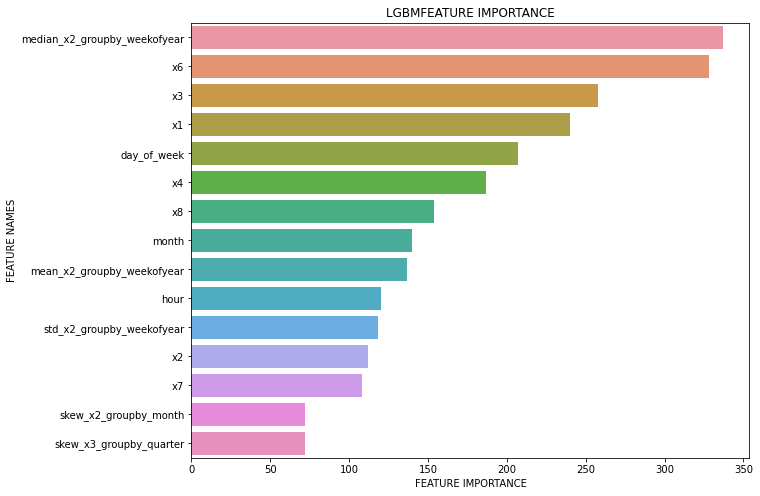

In [127]:
plot_feature_importance(lgbm_models_y2[-1].feature_importances_,X_train.columns,'LGBM')

In [117]:
lgbm_models[0].booster_.save_model('lgbr_base_y2.txt')

# Combine all models and predict next 14 days 

## Create data and feature engineering next 14 days

In [35]:
df.columns

Index(['Description', 'y1', 'y2', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7',
       'x8', 'date', 'hour', 'month', 'minute', 'year', 'year_month',
       'Timestamp', 'day', 'day_of_week', 'target', 'quarter', 'week_of_year',
       'median_x2_groupby_month', 'mean_x2_groupby_month',
       'std_x2_groupby_month', 'max_x2_groupby_month', 'min_x2_groupby_month',
       'skew_x2_groupby_month', 'median_x3_groupby_quarter',
       'mean_x3_groupby_quarter', 'std_x3_groupby_quarter',
       'max_x3_groupby_quarter', 'min_x3_groupby_quarter',
       'skew_x3_groupby_quarter', 'median_x2_groupby_weekofyear',
       'mean_x2_groupby_weekofyear', 'std_x2_groupby_weekofyear',
       'max_x2_groupby_weekofyear', 'min_x2_groupby_weekofyear',
       'skew_x2_groupby_weekofyear', 'median_x3_groupby_dayofweek',
       'mean_x3_groupby_dayofweek', 'std_x3_groupby_dayofweek',
       'max_x3_groupby_dayofweek', 'min_x3_groupby_dayofweek',
       'skew_x3_groupby_dayofweek'],
      dtype='object')

In [9]:
columns = ['Description', 'y1', 'y2', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7',
       'x8', 'date', 'hour', 'month', 'minute', 'year', 'year_month',
       'Timestamp', 'day', 'day_of_week', 'target', 'quarter']
future_df = pd.DataFrame(columns=columns, index=pd.period_range(start='2017-07-02 00:00:00', end='2017-07-15 23:55:00', freq='5T').to_timestamp()).reset_index()
future_df.drop(columns=['Description'], inplace=True)
future_df = future_df.rename(columns={'index': 'Description'})

In [10]:
future_df['Timestamp'] = pd.to_datetime(future_df['Description'], format='%Y-%m-%d %H:%M:%S')
future_df['date'] = future_df['Timestamp'].dt.date.astype(str)
future_df['year'] = future_df['Timestamp'].dt.year.astype(str)
future_df['day'] = future_df['Timestamp'].dt.day.astype(int)
future_df['hour'] = future_df['Timestamp'].dt.hour.astype(int)
future_df['month'] = future_df['Timestamp'].dt.month.astype(int)
future_df['minute'] = future_df['Timestamp'].dt.minute.astype(int)
future_df['year_month'] = future_df['Timestamp'].dt.to_period('M')
future_df['day_of_week'] = future_df['Timestamp'].dt.day_of_week
future_df['quarter'] = future_df['Timestamp'].dt.quarter

In [11]:
future_df

Description   y1   y2   x1   x2   x3   x4   x5   x6   x7  ...  \
0    2017-07-02 00:00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
1    2017-07-02 00:05:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2    2017-07-02 00:10:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
3    2017-07-02 00:15:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
4    2017-07-02 00:20:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
...                  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
4027 2017-07-15 23:35:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
4028 2017-07-15 23:40:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
4029 2017-07-15 23:45:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
4030 2017-07-15 23:50:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
4031 2017-07-15 23:55:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   

     hour month  minute  year  year_month           Timestamp day day_of_week  \
0       0     7       0  2017     2017-07 2017-07-02 00:00:00   2           6   
1       0     7       5  2017     2017-07 2017-07-02 00:05:00   2           6   
2       0     7      10  2017     2017-07 2017-07-02 00:10:00   2           6   
3       0     7      15  2017     2017-07 2017-07-02 00:15:00   2           6   
4       0     7      20  2017     2017-07 2017-07-02 00:20:00   2           6   
...   ...   ...     ...   ...         ...                 ...  ..         ...   
4027   23     7      35  2017     2017-07 2017-07-15 23:35:00  15           5   
4028   23     7      40  2017     2017-07 2017-07-15 23:40:00  15           5   
4029   23     7      45  2017     2017-07 2017-07-15 23:45:00  15           5   
4030   23     7      50  2017     2017-07 2017-07-15 23:50:00  15           5   
4031   23     7      55  2017     2017-07 2017-07-15 23:55:00  15           5   

      target  quarter  
0        NaN        3  
1        NaN        3  
2        NaN        3  
3        NaN        3  
4        NaN        3  
...      ...      ...  
4027     NaN        3  
4028     NaN        3  
4029     NaN        3  
4030     NaN        3  
4031     NaN        3  

[4032 rows x 22 columns]

In [12]:
combine_df = pd.concat([origin_df, future_df])
combine_df

Description        y1        y2        x1        x2        x3  \
0     2016-01-01 00:00:00  0.008133  0.805288  0.934119  0.182838  0.282637   
1     2016-01-01 00:05:00  0.008964  0.799772  0.934014  0.180689  0.281720   
2     2016-01-01 00:10:00  0.008906  0.809219  0.934031  0.181439  0.282202   
3     2016-01-01 00:15:00  0.008469  0.804602  0.934367  0.182620  0.282305   
4     2016-01-01 00:20:00  0.006882  0.799026  0.934884  0.180871  0.281051   
...                   ...       ...       ...       ...       ...       ...   
4027  2017-07-15 23:35:00       NaN       NaN       NaN       NaN       NaN   
4028  2017-07-15 23:40:00       NaN       NaN       NaN       NaN       NaN   
4029  2017-07-15 23:45:00       NaN       NaN       NaN       NaN       NaN   
4030  2017-07-15 23:50:00       NaN       NaN       NaN       NaN       NaN   
4031  2017-07-15 23:55:00       NaN       NaN       NaN       NaN       NaN   

            x4        x5        x6        x7  ...  hour month  minute  year  \
0     0.612302  0.218844  0.036615  0.695623  ...     0     1       0  2016   
1     0.611908  0.220869  0.037616  0.693026  ...     0     1       5  2016   
2     0.610927  0.222187  0.034264  0.692654  ...     0     1      10  2016   
3     0.612801  0.221935  0.034894  0.693397  ...     0     1      15  2016   
4     0.610566  0.218883  0.038596  0.690928  ...     0     1      20  2016   
...        ...       ...       ...       ...  ...   ...   ...     ...   ...   
4027       NaN       NaN       NaN       NaN  ...    23     7      35  2017   
4028       NaN       NaN       NaN       NaN  ...    23     7      40  2017   
4029       NaN       NaN       NaN       NaN  ...    23     7      45  2017   
4030       NaN       NaN       NaN       NaN  ...    23     7      50  2017   
4031       NaN       NaN       NaN       NaN  ...    23     7      55  2017   

      year_month            Timestamp day day_of_week  target  quarter  
0        2016-01  2016-01-01 00:00:00   1           4      y2        1  
1        2016-01  2016-01-01 00:05:00   1           4      y2        1  
2        2016-01  2016-01-01 00:10:00   1           4      y2        1  
3        2016-01  2016-01-01 00:15:00   1           4      y2        1  
4        2016-01  2016-01-01 00:20:00   1           4      y2        1  
...          ...                  ...  ..         ...     ...      ...  
4027     2017-07  2017-07-15 23:35:00  15           5     NaN        3  
4028     2017-07  2017-07-15 23:40:00  15           5     NaN        3  
4029     2017-07  2017-07-15 23:45:00  15           5     NaN        3  
4030     2017-07  2017-07-15 23:50:00  15           5     NaN        3  
4031     2017-07  2017-07-15 23:55:00  15           5     NaN        3  

[161868 rows x 22 columns]

In [13]:
def feature_engineering_x14678(df, columns):
    window = 14*24*12

    for column in columns:
        # df[f'{column}_shift_5min'] = df[column].shift(1)
        # df[f'{column}_shift_1h'] = df[column].shift(1 * 12)
        # df[f'{column}_shift_1d'] = df[column].shift(1 * 12 * 24)
        # df[f'{column}_shift_1w'] = df[column].shift(1 * 12 * 24 * 7)
        df[f'{column}_shift_14d'] = df[column].shift(1 * window)
        df[f'{column}_shift_28d'] = df[column].shift(2 * window)
        df[f'{column}_shift_1m'] = df[column].shift(1 * 12 * 24 * 7 * 4)
        df[f'{column}_shift_42d'] = df[column].shift(3 * window)
        df[f'{column}_shift_56d'] = df[column].shift(4 * window)
        df[f'{column}_shift_2m'] = df[column].shift(1 * 12 * 24 * 7 * 8)
    return df

In [14]:
x_columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']

In [15]:
combine_df = feature_engineering_x14678(combine_df, x_columns)
combine_df

Description        y1        y2        x1        x2        x3  \
0     2016-01-01 00:00:00  0.008133  0.805288  0.934119  0.182838  0.282637   
1     2016-01-01 00:05:00  0.008964  0.799772  0.934014  0.180689  0.281720   
2     2016-01-01 00:10:00  0.008906  0.809219  0.934031  0.181439  0.282202   
3     2016-01-01 00:15:00  0.008469  0.804602  0.934367  0.182620  0.282305   
4     2016-01-01 00:20:00  0.006882  0.799026  0.934884  0.180871  0.281051   
...                   ...       ...       ...       ...       ...       ...   
4027  2017-07-15 23:35:00       NaN       NaN       NaN       NaN       NaN   
4028  2017-07-15 23:40:00       NaN       NaN       NaN       NaN       NaN   
4029  2017-07-15 23:45:00       NaN       NaN       NaN       NaN       NaN   
4030  2017-07-15 23:50:00       NaN       NaN       NaN       NaN       NaN   
4031  2017-07-15 23:55:00       NaN       NaN       NaN       NaN       NaN   

            x4        x5        x6        x7  ...  x7_shift_1m x7_shift_42d  \
0     0.612302  0.218844  0.036615  0.695623  ...          NaN          NaN   
1     0.611908  0.220869  0.037616  0.693026  ...          NaN          NaN   
2     0.610927  0.222187  0.034264  0.692654  ...          NaN          NaN   
3     0.612801  0.221935  0.034894  0.693397  ...          NaN          NaN   
4     0.610566  0.218883  0.038596  0.690928  ...          NaN          NaN   
...        ...       ...       ...       ...  ...          ...          ...   
4027       NaN       NaN       NaN       NaN  ...     0.676214     0.697335   
4028       NaN       NaN       NaN       NaN  ...     0.677030     0.699542   
4029       NaN       NaN       NaN       NaN  ...     0.679214     0.702131   
4030       NaN       NaN       NaN       NaN  ...     0.681632     0.703067   
4031       NaN       NaN       NaN       NaN  ...     0.680391     0.706083   

      x7_shift_56d  x7_shift_2m  x8_shift_14d x8_shift_28d x8_shift_1m  \
0              NaN          NaN           NaN          NaN         NaN   
1              NaN          NaN           NaN          NaN         NaN   
2              NaN          NaN           NaN          NaN         NaN   
3              NaN          NaN           NaN          NaN         NaN   
4              NaN          NaN           NaN          NaN         NaN   
...            ...          ...           ...          ...         ...   
4027      0.691353     0.691353      0.231942     0.200503    0.200503   
4028      0.691638     0.691638      0.227148     0.204500    0.204500   
4029      0.692364     0.692364      0.236186     0.193145    0.193145   
4030      0.691227     0.691227      0.242765     0.185805    0.185805   
4031      0.689204     0.689204      0.242006     0.185566    0.185566   

     x8_shift_42d  x8_shift_56d  x8_shift_2m  
0             NaN           NaN          NaN  
1             NaN           NaN          NaN  
2             NaN           NaN          NaN  
3             NaN           NaN          NaN  
4             NaN           NaN          NaN  
...           ...           ...          ...  
4027     0.244228      0.236860     0.236860  
4028     0.246555      0.228400     0.228400  
4029     0.245488      0.235440     0.235440  
4030     0.246119      0.235734     0.235734  
4031     0.249286      0.238380     0.238380  

[161868 rows x 70 columns]

In [27]:
future_df = combine_df[-4032:]

## Predict x1, x4, x6, x7, x8

In [54]:
def predict_x(future_df, model, target_column, feature_columns):
#     feature_columns = [
#           'x1_shift_14d',
#            'x1_shift_28d', 'x1_shift_1m', 'x1_shift_42d', 'x1_shift_56d',
#            'x1_shift_2m', 'x2_shift_14d', 'x2_shift_28d', 'x2_shift_1m',
#            'x2_shift_42d', 'x2_shift_56d', 'x2_shift_2m', 'x3_shift_14d',
#            'x3_shift_28d', 'x3_shift_1m', 'x3_shift_42d', 'x3_shift_56d',
#            'x3_shift_2m', 'x4_shift_14d', 'x4_shift_28d', 'x4_shift_1m',
#            'x4_shift_42d', 'x4_shift_56d', 'x4_shift_2m', 'x5_shift_14d',
#            'x5_shift_28d', 'x5_shift_1m', 'x5_shift_42d', 'x5_shift_56d',
#            'x5_shift_2m', 'x6_shift_14d', 'x6_shift_28d', 'x6_shift_1m',
#            'x6_shift_42d', 'x6_shift_56d', 'x6_shift_2m', 'x7_shift_14d',
#            'x7_shift_28d', 'x7_shift_1m', 'x7_shift_42d', 'x7_shift_56d',
#            'x7_shift_2m', 'x8_shift_14d', 'x8_shift_28d', 'x8_shift_1m',
#            'x8_shift_42d', 'x8_shift_56d', 'x8_shift_2m'
#       ]

#     target_column = 'x1'
    multivariate_df = future_df[['Timestamp'] + [target_column] + feature_columns].copy()
    multivariate_df.columns = ['ds', 'y'] + feature_columns
    X_test = multivariate_df.iloc[:, [0]+ [*range(2,multivariate_df.shape[1])]]

    future_df[target_column] = model.predict(X_test)['yhat']
    return future_df

In [55]:
x14678_feature_columns = [
          'x1_shift_14d',
           'x1_shift_28d', 'x1_shift_1m', 'x1_shift_42d', 'x1_shift_56d',
           'x1_shift_2m', 'x2_shift_14d', 'x2_shift_28d', 'x2_shift_1m',
           'x2_shift_42d', 'x2_shift_56d', 'x2_shift_2m', 'x3_shift_14d',
           'x3_shift_28d', 'x3_shift_1m', 'x3_shift_42d', 'x3_shift_56d',
           'x3_shift_2m', 'x4_shift_14d', 'x4_shift_28d', 'x4_shift_1m',
           'x4_shift_42d', 'x4_shift_56d', 'x4_shift_2m', 'x5_shift_14d',
           'x5_shift_28d', 'x5_shift_1m', 'x5_shift_42d', 'x5_shift_56d',
           'x5_shift_2m', 'x6_shift_14d', 'x6_shift_28d', 'x6_shift_1m',
           'x6_shift_42d', 'x6_shift_56d', 'x6_shift_2m', 'x7_shift_14d',
           'x7_shift_28d', 'x7_shift_1m', 'x7_shift_42d', 'x7_shift_56d',
           'x7_shift_2m', 'x8_shift_14d', 'x8_shift_28d', 'x8_shift_1m',
           'x8_shift_42d', 'x8_shift_56d', 'x8_shift_2m'
      ]

In [62]:
for x in ['x1', 'x4', 'x6', 'x7', 'x8']:
    with open(f'model_{x}.pkl', 'rb') as f:
        model_x = pickle.load(f)
    future_df = predict_x(future_df, model_x, x, feature_columns=x14678_feature_columns)
future_df

Description  y1  y2        x1  x2  x3        x4  x5        x6  \
0     2017-07-02 00:00:00 NaN NaN  0.983945 NaN NaN  0.665345 NaN  0.003185   
1     2017-07-02 00:05:00 NaN NaN  0.990070 NaN NaN  0.668087 NaN -0.002273   
2     2017-07-02 00:10:00 NaN NaN  0.983954 NaN NaN  0.665171 NaN  0.003254   
3     2017-07-02 00:15:00 NaN NaN  0.981153 NaN NaN  0.662210 NaN  0.005900   
4     2017-07-02 00:20:00 NaN NaN  0.976635 NaN NaN  0.659723 NaN  0.010579   
...                   ...  ..  ..       ...  ..  ..       ...  ..       ...   
4027  2017-07-15 23:35:00 NaN NaN  1.356922 NaN NaN  0.950064 NaN -0.423568   
4028  2017-07-15 23:40:00 NaN NaN  1.339169 NaN NaN  0.937332 NaN -0.404851   
4029  2017-07-15 23:45:00 NaN NaN  1.352516 NaN NaN  0.946973 NaN -0.419160   
4030  2017-07-15 23:50:00 NaN NaN  1.352235 NaN NaN  0.949259 NaN -0.420063   
4031  2017-07-15 23:55:00 NaN NaN  1.356337 NaN NaN  0.949901 NaN -0.424272   

            x7  ...  x7_shift_1m x7_shift_42d  x7_shift_56d  x7_shift_2m  \
0     0.719778  ...     0.705000     0.690614      0.108820     0.108820   
1     0.721710  ...     0.706318     0.689400      0.108306     0.108306   
2     0.718499  ...     0.703466     0.694862      0.109686     0.109686   
3     0.715652  ...     0.699481     0.690562      0.108420     0.108420   
4     0.714330  ...     0.697877     0.686625      0.108726     0.108726   
...        ...  ...          ...          ...           ...          ...   
4027  0.873063  ...     0.676214     0.697335      0.691353     0.691353   
4028  0.860963  ...     0.677030     0.699542      0.691638     0.691638   
4029  0.870585  ...     0.679214     0.702131      0.692364     0.692364   
4030  0.874623  ...     0.681632     0.703067      0.691227     0.691227   
4031  0.873800  ...     0.680391     0.706083      0.689204     0.689204   

      x8_shift_14d x8_shift_28d x8_shift_1m x8_shift_42d  x8_shift_56d  \
0         0.191485     0.242861    0.242861     0.234330      0.930171   
1         0.179113     0.251702    0.251702     0.234662      0.930283   
2         0.186867     0.248224    0.248224     0.242496      0.930243   
3         0.181481     0.247136    0.247136     0.236501      0.930096   
4         0.180379     0.244471    0.244471     0.236549      0.929865   
...            ...          ...         ...          ...           ...   
4027      0.231942     0.200503    0.200503     0.244228      0.236860   
4028      0.227148     0.204500    0.204500     0.246555      0.228400   
4029      0.236186     0.193145    0.193145     0.245488      0.235440   
4030      0.242765     0.185805    0.185805     0.246119      0.235734   
4031      0.242006     0.185566    0.185566     0.249286      0.238380   

      x8_shift_2m  
0        0.930171  
1        0.930283  
2        0.930243  
3        0.930096  
4        0.929865  
...           ...  
4027     0.236860  
4028     0.228400  
4029     0.235440  
4030     0.235734  
4031     0.238380  

[4032 rows x 70 columns]


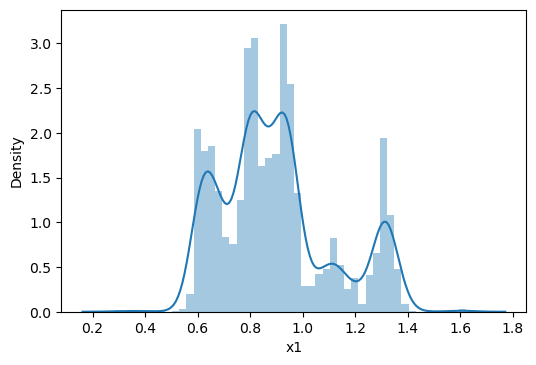

In [63]:
describe_1d_numerical(future_df, 'x1')


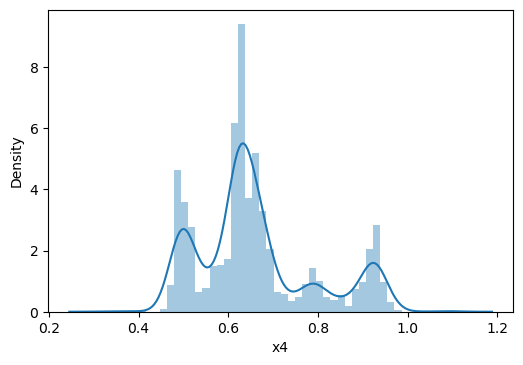

In [64]:
describe_1d_numerical(future_df, 'x4')


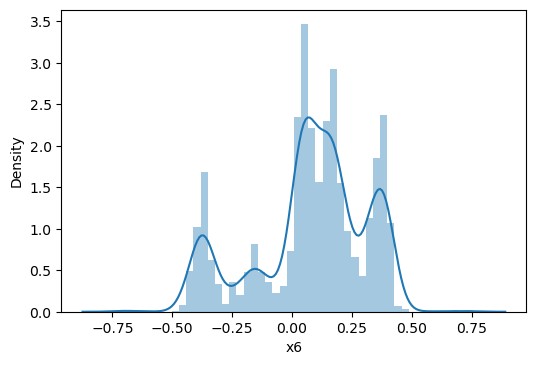

In [65]:
describe_1d_numerical(future_df, 'x6')


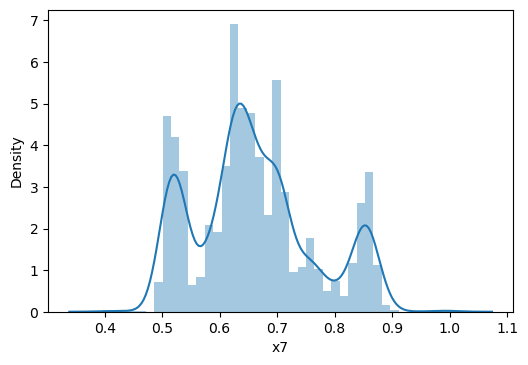

In [66]:
describe_1d_numerical(future_df, 'x7')


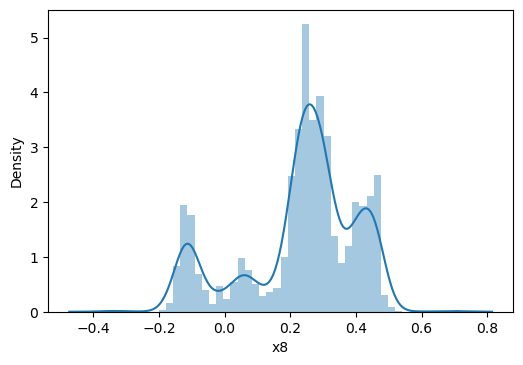

In [67]:
describe_1d_numerical(future_df, 'x8')

## predict x5

In [49]:
x5_feature_columns = ['x1', 'x4', 'x6', 'x7', 'x8', 'x4_shift_14d',
       'x4_shift_28d', 'x4_shift_1m', 'x4_shift_42d', 'x4_shift_56d',
       'x4_shift_2m', 'x5_shift_14d', 'x5_shift_28d', 'x5_shift_1m',
       'x5_shift_42d', 'x5_shift_56d', 'x5_shift_2m']

In [68]:
with open(f'model_x5.pkl', 'rb') as f:
    model_x = pickle.load(f)
future_df = predict_x(future_df, model_x, 'x5', feature_columns=x5_feature_columns)
future_df

Description  y1  y2        x1  x2  x3        x4        x5  \
0     2017-07-02 00:00:00 NaN NaN  0.983945 NaN NaN  0.665345  0.240386   
1     2017-07-02 00:05:00 NaN NaN  0.990070 NaN NaN  0.668087  0.241981   
2     2017-07-02 00:10:00 NaN NaN  0.983954 NaN NaN  0.665171  0.240248   
3     2017-07-02 00:15:00 NaN NaN  0.981153 NaN NaN  0.662210  0.237583   
4     2017-07-02 00:20:00 NaN NaN  0.976635 NaN NaN  0.659723  0.236366   
...                   ...  ..  ..       ...  ..  ..       ...       ...   
4027  2017-07-15 23:35:00 NaN NaN  1.356922 NaN NaN  0.950064  0.444928   
4028  2017-07-15 23:40:00 NaN NaN  1.339169 NaN NaN  0.937332  0.435114   
4029  2017-07-15 23:45:00 NaN NaN  1.352516 NaN NaN  0.946973  0.442382   
4030  2017-07-15 23:50:00 NaN NaN  1.352235 NaN NaN  0.949259  0.444344   
4031  2017-07-15 23:55:00 NaN NaN  1.356337 NaN NaN  0.949901  0.444364   

            x6        x7  ...  x7_shift_1m x7_shift_42d  x7_shift_56d  \
0     0.003185  0.719778  ...     0.705000     0.690614      0.108820   
1    -0.002273  0.721710  ...     0.706318     0.689400      0.108306   
2     0.003254  0.718499  ...     0.703466     0.694862      0.109686   
3     0.005900  0.715652  ...     0.699481     0.690562      0.108420   
4     0.010579  0.714330  ...     0.697877     0.686625      0.108726   
...        ...       ...  ...          ...          ...           ...   
4027 -0.423568  0.873063  ...     0.676214     0.697335      0.691353   
4028 -0.404851  0.860963  ...     0.677030     0.699542      0.691638   
4029 -0.419160  0.870585  ...     0.679214     0.702131      0.692364   
4030 -0.420063  0.874623  ...     0.681632     0.703067      0.691227   
4031 -0.424272  0.873800  ...     0.680391     0.706083      0.689204   

      x7_shift_2m  x8_shift_14d x8_shift_28d x8_shift_1m x8_shift_42d  \
0        0.108820      0.191485     0.242861    0.242861     0.234330   
1        0.108306      0.179113     0.251702    0.251702     0.234662   
2        0.109686      0.186867     0.248224    0.248224     0.242496   
3        0.108420      0.181481     0.247136    0.247136     0.236501   
4        0.108726      0.180379     0.244471    0.244471     0.236549   
...           ...           ...          ...         ...          ...   
4027     0.691353      0.231942     0.200503    0.200503     0.244228   
4028     0.691638      0.227148     0.204500    0.204500     0.246555   
4029     0.692364      0.236186     0.193145    0.193145     0.245488   
4030     0.691227      0.242765     0.185805    0.185805     0.246119   
4031     0.689204      0.242006     0.185566    0.185566     0.249286   

      x8_shift_56d  x8_shift_2m  
0         0.930171     0.930171  
1         0.930283     0.930283  
2         0.930243     0.930243  
3         0.930096     0.930096  
4         0.929865     0.929865  
...            ...          ...  
4027      0.236860     0.236860  
4028      0.228400     0.228400  
4029      0.235440     0.235440  
4030      0.235734     0.235734  
4031      0.238380     0.238380  

[4032 rows x 70 columns]


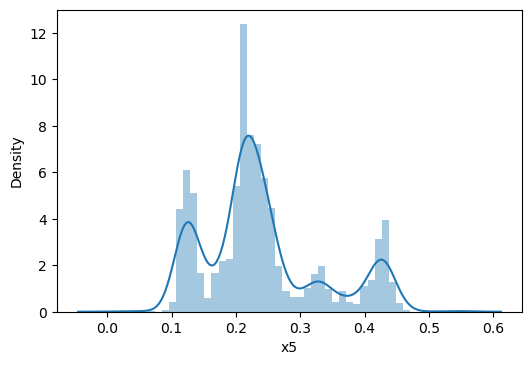

In [69]:
describe_1d_numerical(future_df, 'x5')

## Predict x2, x3

In [72]:
x23_feature_columns = ['x1', 'x4', 'x5', 'x6', 'x7', 'x4_shift_14d',
       'x4_shift_28d', 'x4_shift_1m', 'x4_shift_42d', 'x4_shift_56d',
       'x4_shift_2m', 'x5_shift_14d', 'x5_shift_28d', 'x5_shift_1m',
       'x5_shift_42d', 'x5_shift_56d', 'x5_shift_2m', 'x2_shift_14d',
       'x2_shift_28d', 'x2_shift_1m', 'x2_shift_42d', 'x2_shift_56d',
       'x2_shift_2m', 'x3_shift_14d', 'x3_shift_28d', 'x3_shift_1m',
       'x3_shift_42d', 'x3_shift_56d', 'x3_shift_2m']

In [73]:
with open(f'model_x2.pkl', 'rb') as f:
    model_x = pickle.load(f)
future_df = predict_x(future_df, model_x, 'x2', feature_columns=x23_feature_columns)

with open(f'model_x3.pkl', 'rb') as f:
    model_x = pickle.load(f)
future_df = predict_x(future_df, model_x, 'x3', feature_columns=x23_feature_columns)


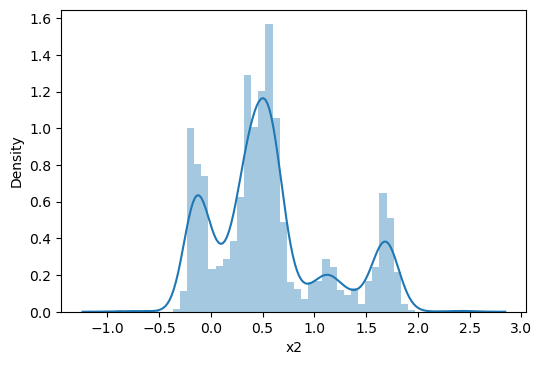

In [74]:
describe_1d_numerical(future_df, 'x2')


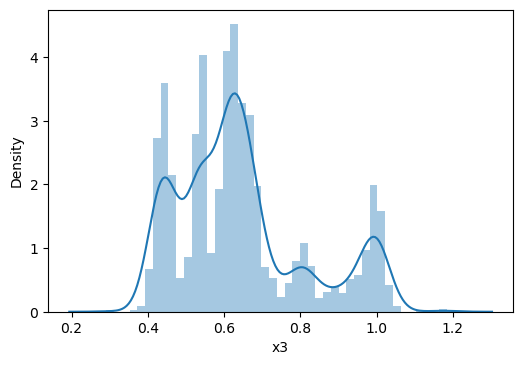

In [75]:
describe_1d_numerical(future_df, 'x3')

## predict y1, y2

In [132]:
future_df = feature_engineering_y1y2(future_df)

In [133]:
features = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7',
       'x8', 'hour', 'month', 'day_of_week', 'quarter', 
       'median_x2_groupby_month', 'mean_x2_groupby_month',
       'std_x2_groupby_month', 'max_x2_groupby_month', 'min_x2_groupby_month',
       'skew_x2_groupby_month', 'median_x3_groupby_quarter',
       'mean_x3_groupby_quarter', 'std_x3_groupby_quarter',
       'max_x3_groupby_quarter', 'min_x3_groupby_quarter',
       'skew_x3_groupby_quarter', 'median_x2_groupby_weekofyear',
       'mean_x2_groupby_weekofyear', 'std_x2_groupby_weekofyear',
       'max_x2_groupby_weekofyear', 'min_x2_groupby_weekofyear',
       'skew_x2_groupby_weekofyear', 'median_x3_groupby_dayofweek',
       'mean_x3_groupby_dayofweek', 'std_x3_groupby_dayofweek',
       'max_x3_groupby_dayofweek', 'min_x3_groupby_dayofweek',
       'skew_x3_groupby_dayofweek']

In [138]:
future_df['y1'] = lgbm_models_y1[0].predict(future_df[features])

In [140]:
future_df['y2'] = lgbm_models_y2[0].predict(future_df[features])


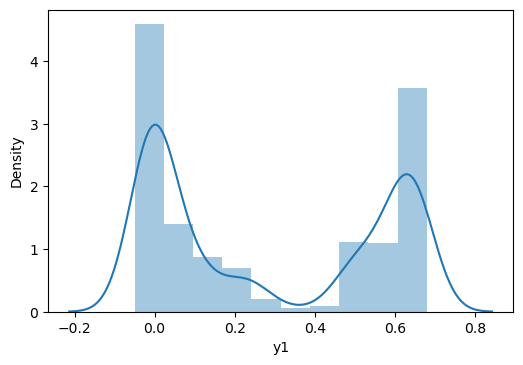

In [141]:
describe_1d_numerical(future_df, 'y1')


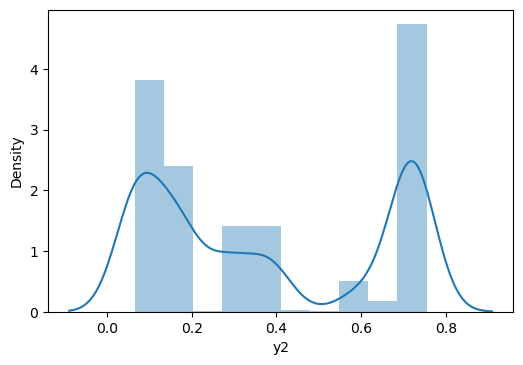

In [142]:
describe_1d_numerical(future_df, 'y2')

In [143]:
future_df.to_csv('predicted_data.csv', header=True, index=False)